<a href="https://colab.research.google.com/github/jylin04/mi-ntk/blob/main/Number_sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup (run this and *'d cells at start)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import math

import numpy as np
import torch as t

from torch import nn, Tensor
from torch.nn import functional as F

from tqdm.notebook import tqdm

from typing import Tuple, Optional

In [3]:
import matplotlib.pyplot as plt

In [4]:
%pip install -q git+https://github.com/jylin04/mi-ntk.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import ntk, ma

from ma import train, test
from ntk import full_jacobian, class_jacobian, jacobian_by_layer, empirical_ntk, empirical_ntk_by_layer, empirical_ntk_by_layer_cpu, LinearisedPredictor, eig_decompose

# 1. Reproduce baseline results

## Train the toy model

In [6]:
class HyperParams:
  list_len: int = 4
  max_value: int = 10
  trainset_size: int = 2048
  val_size: int = 1024
  d_model: int = 48
  n_heads: int = 1
  wd: float = 0.005
  lr: float = 1e-3
  batch_size: int = 64
  epochs: int = 25
  #eval_every: int = 100
  log_every: int = 20
  seed: int = 0

params = HyperParams()
t.manual_seed(params.seed)

device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [7]:
'''class HyperParams:
  list_len: int= 10
  max_value: int = 50
  trainset_size: int = 150_000
  val_size: int = 10_000
  d_model: int = 96
  n_heads: int = 2
  wd: float = 0.005
  lr: float = 1e-3
  batch_size: int = 512
  epochs: int = 25
  #eval_every: int = 100
  log_every: int = 20
  seed: int = 0

params = HyperParams()
t.manual_seed(params.seed)

device = t.device("cuda" if t.cuda.is_available() else "cpu")'''

'class HyperParams:\n  list_len: int= 10\n  max_value: int = 50\n  trainset_size: int = 150_000\n  val_size: int = 10_000\n  d_model: int = 96\n  n_heads: int = 2\n  wd: float = 0.005\n  lr: float = 1e-3\n  batch_size: int = 512\n  epochs: int = 25\n  #eval_every: int = 100\n  log_every: int = 20\n  seed: int = 0\n\nparams = HyperParams()\nt.manual_seed(params.seed)\n\ndevice = t.device("cuda" if t.cuda.is_available() else "cpu")'

In [7]:
# -------- Dataset --------

def sortedlist_dataset(N: int, list_len: int, max_value: int):
  """
  Return a dataset of N sorted lists of the form [a_1, ...a_n, SEP, b_1, ...b_n]
  where b_1, ... b_n is the sorted version of a_1, ... a_n (in increasing order),
  with n = list_len and a_i's drawn from 0 to max_value without replacement."""

  vocab = [str(i) for i in range(max_value+1)] + ["SEP"]

  sep_toks = t.full((N, 1), fill_value = vocab.index("SEP"))
  unsorted_list = t.argsort(t.rand(N, max_value+1), dim=-1)[:, :list_len]
  sorted_list = t.sort(unsorted_list, dim=-1).values
  toks = t.cat([unsorted_list, sep_toks, sorted_list], dim=-1)

  #str_toks = [[vocab[i] for i in toks] for toks in toks.tolist()]

  return toks

In [8]:
trainset = sortedlist_dataset(params.trainset_size, params.list_len, params.max_value)
valset = sortedlist_dataset(params.val_size, params.list_len, params.max_value)

In [9]:
print(trainset[1])

tensor([ 1,  7,  2,  8, 11,  1,  2,  7,  8])


In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(trainset, batch_size = params.batch_size, shuffle=True)
test_loader = DataLoader(valset, batch_size = params.batch_size, shuffle=False)

In [11]:
for batch in train_loader:
    first_batch = batch
    break

In [12]:
print(first_batch.shape)

torch.Size([64, 9])


In [13]:
# --------- Model --------

# --- DIY embeding layers ---

class Embed(nn.Module):
  """
  Lookup table from tokens to learned embedding.
  Input:  (batch, seq_pos)
  Output: (batch, seq_pos, d_model)
  """
  def __init__(self, d_vocab: int, d_model: int):
    super().__init__()
    self.W_E = nn.Parameter(t.randn(d_vocab, d_model)/np.sqrt(d_model))

  def forward(self, x):
    return self.W_E[x]



class PosEmbed(nn.Module):
  """
  Lookup table from sequence index to learned embedding.
  Input:  (batch, seq_pos)
  Output: (batch, seq_pos, d_model)
  """
  def __init__(self, seq_len: int, d_model: int):
    super().__init__()
    self.W_pos = nn.Parameter(t.randn(seq_len, d_model)/np.sqrt(d_model))

  def forward(self, x):
    batch_size, _ = x.shape
    return self.W_pos.unsqueeze(0).repeat(batch_size, 1, 1)



class Unembed(nn.Module):
  """
  Input: (batch, seq_pos, d_model)
  Output:(batch, seq_pos, d_vocab)
  """
  def __init__(self, d_vocab: int, d_model: int):
    super().__init__()
    self.W_U = nn.Parameter(t.randn(d_model, d_vocab)/np.sqrt(d_vocab))

  def forward(self, x):
    return x @ self.W_U



class Attention(nn.Module):
  """
  Input: (batch, seq_pos, d_model)
  Output:(batch, seq_pos, d_model)

  We'll omit bias terms following the experiment in https://arxiv.org/pdf/2301.05217.
  """
  def __init__(self, d_model: int, n_heads: int):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_head = d_model // n_heads

    self.W_Q = nn.Parameter(t.randn(n_heads, self.d_head, d_model)/np.sqrt(d_model))
    self.W_K = nn.Parameter(t.randn(n_heads, self.d_head, d_model)/np.sqrt(d_model))
    self.W_V = nn.Parameter(t.randn(n_heads, self.d_head, d_model)/np.sqrt(d_model))
    self.W_O = nn.Parameter(t.randn(n_heads, d_model, self.d_head) / np.sqrt(d_model))
    #self.W_O = nn.Parameter(t.randn(d_model, d_model)/np.sqrt(d_model))


  def forward(self, x):
    q = t.einsum('n h m, b s m -> b s n h', self.W_Q, x)  #     q = t.einsum('n_heads d_head d_model, batch seq_pos d_model -> batch seq_pos n_heads d_head', self.W_Q, x)
    k = t.einsum('n h m, b s m -> b s n h', self.W_K, x)
    v = t.einsum('n h m, b s m -> b s n h', self.W_V, x)

    attn = t.einsum('b q n h, b k n h -> b n q k', q, k)/np.sqrt(self.d_head)  #     attn = t.einsum('batch seq_q n_heads d_head, batch seq_k n_heads d_head -> batch n_heads seq_q seq_k', q, k)

    _, seq_len, _ = x.shape
    causal_mask = t.triu(t.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
    attn = attn.masked_fill(causal_mask.unsqueeze(0).unsqueeze(0), float('-inf'))
    attn = F.softmax(attn, dim=-1)

    z = t.einsum('b n q k, b k n h -> b q n h', attn, v)

    #z_flat = t.flatten(z, start_dim=2, end_dim=3)
    #out = t.einsum('m n, b s n -> b s m', self.W_O, z_flat)

    out_h = t.einsum('b s n h, n m h -> b s n m', z, self.W_O)
    out = out_h.sum(dim=2)

    return out



class AttnOnly_Block(nn.Module):
  def __init__(self, d_model: int, n_heads: int):
    super().__init__()
    self.ln1 = nn.LayerNorm(d_model)
    self.attn = Attention(d_model, n_heads)

  def forward(self, x):
    x = x + self.attn(self.ln1(x))
    return x



# --- Full model ---

class NSTransformer(nn.Module):
  """
  1L GPT-style Attention-only Transformer.
  Input: (batch, seq_pos)
  Output: (batch, seq_pos, d_vocab)
  """
  def __init__(self, seq_len: int, d_vocab: int, d_model: int, n_heads: int):
    super().__init__()
    self.embed = Embed(d_vocab, d_model)
    #self.pos_embed = PosEmbed(seq_len, d_model)
    self.attn_block = AttnOnly_Block(d_model, n_heads)
    #self.ln_final = nn.LayerNorm(d_model)
    self.unembed = Unembed(d_vocab, d_model)

  def forward(self, x):
    x = self.embed(x) #+ self.pos_embed(x)
    x = self.attn_block(x)
    #x = self.ln_final(x)
    x = self.unembed(x)
    return x

In [14]:
model = NSTransformer(params.list_len*2+1, params.max_value+2, params.d_model, params.n_heads).to(device)
opt = t.optim.AdamW(model.parameters(), lr = params.lr, weight_decay = params.wd)

In [15]:
def loss_fn(model_out: t. Tensor, toks: t.Tensor):
  """
  model_out: (batch, seq_pos = 2* list_len +1, d_vocab)
  toks = (batch, seq_pos = 2*list_len+1)

  Each sequence has the form [a_1, ... a_n, SEP, b_1 ... b_n].

  The loss function should compute cross entropy loss between the model
  predictions from SEP to b_{n-1} and target from b-1 to b-n.
  """

  logits = model_out[:, params.list_len:-1 , :]
  logprobs = logits.log_softmax(dim=-1)
  targets = toks[:,params.list_len+1:]
  loss = F.cross_entropy(logprobs.reshape(-1, logits.shape[-1]), targets.reshape(-1))
  return loss

In [16]:
tr_loss = []
te_acc = []

for epoch in range(params.epochs):

  progress_bar = tqdm(params.trainset_size // params.batch_size)

  # Training
  model.train()
  for x in train_loader:
    x = x.to(device)
    opt.zero_grad()
    out = model(x)
    loss = loss_fn(out, x)
    loss.backward()
    opt.step()
    tr_loss.append(loss.item())

    progress_bar.update()
    progress_bar.set_description(f"Epoch {epoch}, Train Loss {loss.item():.4f}")

  # Validation
  model.eval()
  correct = 0
  with t.no_grad():
    for x in test_loader:
      x= x.to(device)
      out = model(x)
      logits = out[:, params.list_len:-1 , :]
      predictions = logits.argmax(dim=-1)
      targets = x[:,params.list_len+1:]
      correct += (predictions == targets).sum().item()
    accuracy = 100* correct / (params.val_size * (params.list_len))
    te_acc.append(accuracy)

    progress_bar.set_description(f"Epoch {epoch}, Train Loss {loss.item():.4f}, Accuracy: {accuracy:.4f}")


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Seems we can get good performance on quite small models, with dataset size / number of parameters comparable to the modular arithmetic one! Next is to check that the small solution reproduces the right pheno signatures.

## Check pheno signatures

In [17]:
W_OV = t.einsum('n h a, n b h -> n a b', model.attn_block.attn.W_V, model.attn_block.attn.W_O) # [head d_model_in d_model_out]
W_OV_full = model.embed.W_E @ W_OV @ model.unembed.W_U # [head, d_vocab, d_vocab]

W_QK = t.einsum('n h a, n h b -> n a b', model.attn_block.attn.W_Q, model.attn_block.attn.W_K) # [head d_model_dest d_model_src]
W_QK_full = model.embed.W_E @ W_QK @ model.embed.W_E.T # [head, d_vocab, d_vocab]
#W_QK_full = model.embed.W_E @ W_QK @ model.unembed.W_U # [head, d_vocab, d_vocab]

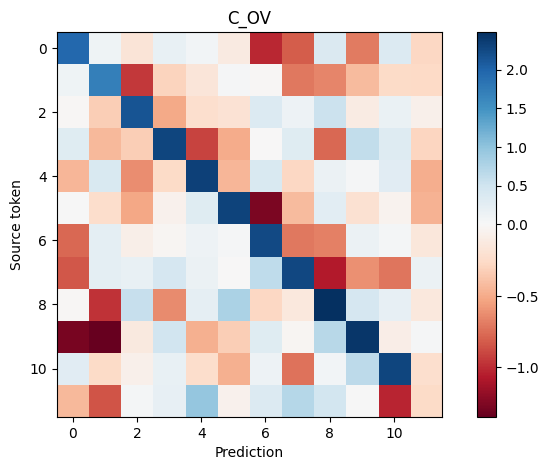

In [20]:
from matplotlib.colors import TwoSlopeNorm

W = W_OV_full[0].cpu().detach().numpy()
norm = TwoSlopeNorm(vmin=np.min(W), vcenter=0.0, vmax=np.max(W))

fig, ax = plt.subplots(figsize=(9, 5))
im = ax.imshow(W, cmap = 'RdBu', norm=norm)
ax.set_xlabel("Prediction")
ax.set_ylabel("Source token")
ax.set_title("C_OV")
plt.colorbar(im, ax=ax)


    #labels = {"x": "Prediction", "y": "Source token"},
    #title = "W<sub>OV</sub> for layer 1 (shows that the heads are copying)",
    #width = 900,
    #height = 500,
    #facet_col = 0,
    #facet_labels = [f"W<sub>OV</sub> [0.{h0}]" for h0 in range(params.n_heads)]
#)

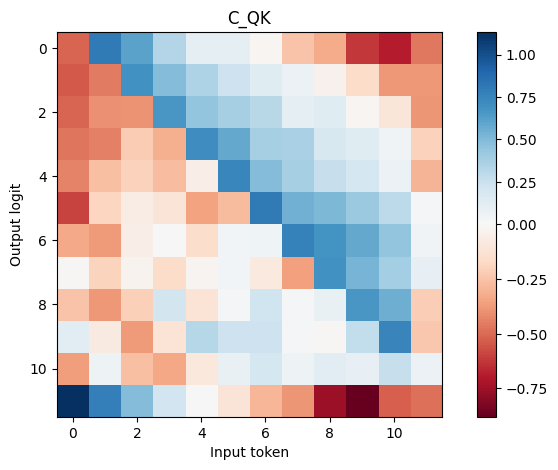

In [21]:
W = W_QK_full[0].cpu().detach().numpy()
norm = TwoSlopeNorm(vmin=np.min(W), vcenter=0.0, vmax=np.max(W))

fig, ax = plt.subplots(figsize=(9, 5))
im = ax.imshow(W, cmap = 'RdBu', norm=norm)
ax.set_xlabel("Input token")
ax.set_ylabel("Output logit")
ax.set_title("C_QK")
plt.colorbar(im, ax=ax)

# 2. Interpret eNTK spectrum.

## 2.1. Kernels

In [22]:
# NB: this takes about 4min to run

entk = empirical_ntk_by_layer_cpu(model.to(device), trainset.to(device), trainset.to(device))

In [23]:
print(*entk)

embed.W_E attn_block.ln1.weight attn_block.ln1.bias attn_block.attn.W_Q attn_block.attn.W_K attn_block.attn.W_V attn_block.attn.W_O unembed.W_U


In [24]:
entk['embed.W_E'][:,:,:11,:11].shape

torch.Size([2048, 2048, 11, 11])

In [25]:
vals = list(entk.values())
entk_full = t.zeros_like(vals[0])
for K in vals:
  entk_full += K

In [26]:
eigvals, eigvecs = eig_decompose((entk_full[:,:,:11,:11]).mean(dim=(2,3)), topk=40)

In [27]:
eigvals, eigvecs = eig_decompose(((entk['embed.W_E'])[:,:,:11,:11]).mean(dim=(2,3)), topk=40)

In [29]:
eigvals, eigvecs = eig_decompose((entk['attn_block.attn.W_Q'][:,:,:11,:11] + entk['attn_block.attn.W_K'][:,:,:11,:11]).mean(dim=(2,3)), topk=40)

In [46]:
eigvals, eigvecs = eig_decompose((entk['attn_block.attn.W_Q'][:,:,10,10] + entk['attn_block.attn.W_K'][:,:,10,10]), topk=40)

In [31]:
eigvals, eigvecs = eig_decompose((entk['attn_block.attn.W_O'][:,:,:11,:11] + entk['attn_block.attn.W_V'][:,:,:11,:11]).mean(dim=(2,3)), topk=40)

In [55]:
eigvals, eigvecs = eig_decompose((entk['attn_block.attn.W_O'][:,:,10,10] + entk['attn_block.attn.W_V'][:,:,10,10]), topk=40)

In [33]:
eigvals, eigvecs = eig_decompose(((entk['unembed.W_U'])[:,:,:11,:11]).mean(dim=(2,3)), topk=40)

In [36]:
eigvals, eigvecs = eig_decompose(((entk['unembed.W_U'])[:,:,10,10]), topk=40)

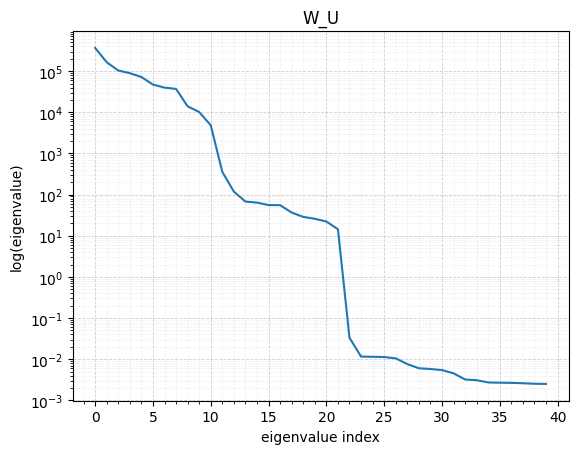

In [35]:
plt.plot(eigvals[:40].detach().cpu().numpy())
plt.yscale('log')
plt.title("W_U")
plt.xlabel("eigenvalue index")
plt.ylabel("log(eigenvalue)")


plt.minorticks_on()
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.6, alpha=0.6)
plt.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5, alpha=0.4)

**TODO**: Con't from here with 2 heads + per-head version - then unsupervisedly interpret the cliffs